# Normalisation

In [ ]:
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler

# --- Load data ---
gdf = gpd.read_file("/content/drive/MyDrive/data_set/merge/clean/feature_extraction/data_final.gpkg")

# --- Columns to normalize (exclude fire, GRIDCODE, geometry) ---
exclude_cols = ['fire', 'GRIDCODE', 'geometry']
cols_to_norm = [c for c in gdf.columns if c not in exclude_cols]

# --- Apply Min-Max normalization ---
scaler = MinMaxScaler()
gdf[cols_to_norm] = scaler.fit_transform(gdf[cols_to_norm])

# --- Check results ---
print(gdf.head())


   fire   tmin_s1   tmin_s2   tmax_s1   tmax_s2     ndvi1  elevation1  \
0  True  0.205674  0.170330  0.169591  0.123596  0.569171    0.883593   
1  True  0.758865  0.510989  0.725146  0.438202  0.720793    0.058662   
2  True  0.758865  0.510989  0.725146  0.438202  0.594049    0.060495   
3  True  0.758865  0.510989  0.725146  0.438202  0.598924    0.058662   
4  True  0.758865  0.510989  0.725146  0.438202  0.594049    0.060495   

    aspect1      SAND      SILT  ...   TOTAL_N       TEB  ALUM_SAT  ELEC_COND  \
0  0.019041  0.588889  0.563636  ...  0.615114  0.082759  0.047619   0.570589   
1  0.898802  0.388889  0.600000  ...  0.583480  0.131034  0.047619   0.570589   
2  0.007061  0.388889  0.600000  ...  0.583480  0.131034  0.047619   0.570589   
3  0.898802  0.388889  0.600000  ...  0.583480  0.131034  0.047619   0.570589   
4  0.007061  0.388889  0.600000  ...  0.583480  0.131034  0.047619   0.570589   

   GRIDCODE  precip_s1_log10  precip_s2_log10  precip_s3_log10  \
0     13

#Remove duplicates

In [ ]:

# Columns to group by (ignore fire and geometry)
group_cols = gdf.columns.difference(['fire', 'geometry'])

# Aggregate duplicates
gdf_clean = (
    gdf
    .groupby(list(group_cols), as_index=False)  # group by all features except fire & geometry
    .agg({'fire': 'max', 'geometry': 'first'})  # keep fire=1 if any, else 0; keep first geometry
)

# Print number of rows before and after
print("Total rows before resolving duplicates:", len(gdf))
print("Total rows after resolving duplicates:", len(gdf_clean))

# Replace original gdf
gdf = gdf_clean

import geopandas as gpd

# Convert back to GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs="EPSG:4326")  # use your actual CRS

# Save to GPKG
output_path = "/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg"
gdf.to_file(output_path, driver="GPKG")


Total rows before resolving duplicates: 12248
Total rows after resolving duplicates: 11829


In [ ]:
print(gdf.columns)

Index(['ALUM_SAT', 'CLAY', 'ELEC_COND', 'GRIDCODE', 'ORG_CARBON', 'PH_WATER',
       'SAND', 'SILT', 'TEB', 'TOTAL_N', 'aspect1', 'elevation1', 'ndvi1',
       'precip_s1_log10', 'precip_s2_log10', 'precip_s3_log10',
       'precip_s4_log10', 'tmax_s1', 'tmax_s2', 'tmin_s1', 'tmin_s2', 'fire',
       'geometry'],
      dtype='object')


## KNN from scratch

Accuracy : 0.81
Precision: 0.57
Recall   : 0.54
F1-score : 0.55


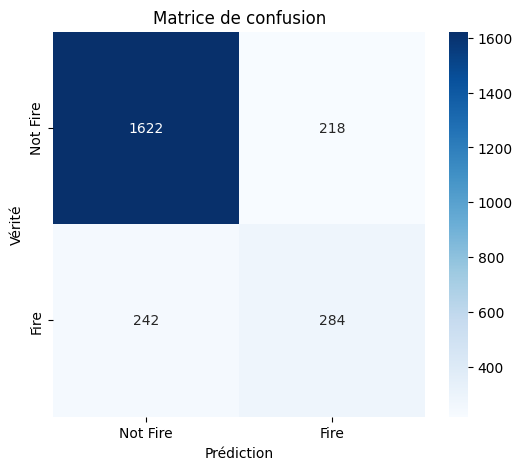

In [ ]:
import geopandas as gpd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
# -----------------------------
# KNN from scratch avec distance mixte
# -----------------------------
class KNNMixed:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.grid_index = None

    def fit(self, X, y, grid_index=None):
        self.X_train = X
        self.y_train = y
        self.grid_index = grid_index

    def gower_distance(self, x1, x2):
        """Distance mixte : Gower pour GRIDECODE et Euclidienne pour le reste"""
        total_dist = 0
        total_dist_eucli = 0
        n_features = len(x1)
        for i in range(n_features):
            if i == self.grid_index:
                # Gower-like pour GRIDECODE
                total_dist += 0 if x1[i] == x2[i] else 1
            else:
                # Euclidienne normalisée par feature
                total_dist_eucli += (x1[i] - x2[i])**2
        total_dist+= np.sqrt(total_dist_eucli)
        return total_dist/2.

    def predict_one(self, x):
        distances = [self.gower_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])


# -----------------------------
# Charger le GeoPackage
# -----------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg")
df = gdf.drop(columns="geometry")

# Convertir la colonne cible True/False en 0/1
df['fire'] = df['fire'].astype(int)

# Identifier l'index de GRIDCODE
grid_index = df.columns.get_loc("GRIDCODE")

# Séparer features et target
X = df.drop(columns=['fire']).values
y = df['fire'].values

# Séparer train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# -----------------------------
# Appliquer KNN mixte
# -----------------------------
k = 5
knn = KNNMixed(k=k)
knn.fit(X_train, y_train, grid_index=grid_index)

y_pred = knn.predict(X_test)

# -----------------------------
# Évaluer le modèle
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
conf_matrix = confusion_matrix(y_test, y_pred)

# Labels pour les classes
labels = ['Not Fire', 'Fire']  # adapter si nécessaire

# Affichage heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.title('Matrice de confusion')
plt.show()


=== Starting Grid Search ===

Tested k=3, p=1, h=1  --> F1=0.6081
Tested k=3, p=1, h=3  --> F1=0.6072
Tested k=3, p=1, h=5  --> F1=0.6059
Tested k=3, p=2, h=1  --> F1=0.5828
Tested k=3, p=2, h=3  --> F1=0.5814
Tested k=3, p=2, h=5  --> F1=0.5814
Tested k=3, p=3, h=1  --> F1=0.5657
Tested k=3, p=3, h=3  --> F1=0.5657
Tested k=3, p=3, h=5  --> F1=0.5657
Tested k=5, p=1, h=1  --> F1=0.5846
Tested k=5, p=1, h=3  --> F1=0.5841
Tested k=5, p=1, h=5  --> F1=0.5827
Tested k=5, p=2, h=1  --> F1=0.5525
Tested k=5, p=2, h=3  --> F1=0.5511
Tested k=5, p=2, h=5  --> F1=0.5511
Tested k=5, p=3, h=1  --> F1=0.5449
Tested k=5, p=3, h=3  --> F1=0.5449
Tested k=5, p=3, h=5  --> F1=0.5449
Tested k=7, p=1, h=1  --> F1=0.5666
Tested k=7, p=1, h=3  --> F1=0.5606
Tested k=7, p=1, h=5  --> F1=0.5577
Tested k=7, p=2, h=1  --> F1=0.5364
Tested k=7, p=2, h=3  --> F1=0.5344
Tested k=7, p=2, h=5  --> F1=0.5344
Tested k=7, p=3, h=1  --> F1=0.5218
Tested k=7, p=3, h=3  --> F1=0.5218
Tested k=7, p=3, h=5  --> F1=0.52

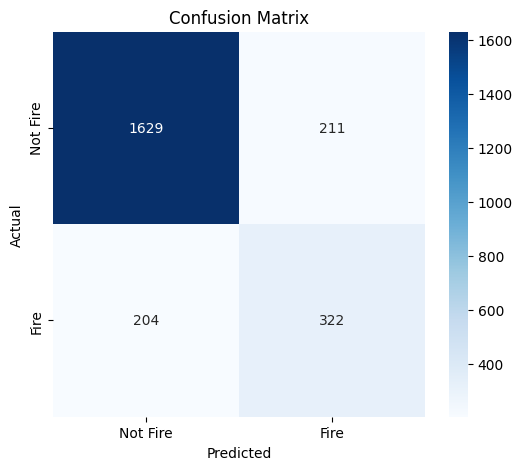

In [ ]:
import geopandas as gpd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# ============================================
#  KNN WITH CUSTOM DISTANCE (MIXED)
# ============================================
class KNNMixed:
    def __init__(self, k=3, p=2, h=1.0):
        self.k = k
        self.p = p
        self.h = h
        self.X_train = None
        self.y_train = None
        self.grid_index = None

    def fit(self, X, y, grid_index=None):
        self.X_train = X
        self.y_train = y
        self.grid_index = grid_index

    def mixed_distance(self, x1, x2):
        """
        Distance mixte :
        - GRIDCODE (catégorielle) pondérée par h
        - Minkowski(p) sur les autres variables
        """
        minkowski_sum = 0

        for i in range(len(x1)):
            if i == self.grid_index:
                # Catégorie : 0 si même classe, h sinon
                cat_dist = 0 if x1[i] == x2[i] else self.h
            else:
                # Minkowski
                minkowski_sum += abs(x1[i] - x2[i]) ** self.p

        mink_dist = minkowski_sum ** (1 / self.p)
        return mink_dist + cat_dist  # on combine les deux

    def predict_one(self, x):
        distances = [self.mixed_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return Counter(k_nearest_labels).most_common(1)[0][0]

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])


# ============================================
# Load dataset
# ============================================
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg")
df = gdf.drop(columns="geometry")

df['fire'] = df['fire'].astype(int)

grid_index = df.columns.get_loc("GRIDCODE")

X = df.drop(columns=['fire']).values
y = df['fire'].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# ============================================
#  GRID SEARCH ON k, p, h
# ============================================
k_values = [3, 5, 7]
p_values = [1, 2, 3]       # Minkowski norms
h_values = [1,3, 5]  # Weight for GRIDCODE

best_score = -1
best_params = None
best_model = None

print("\n=== Starting Grid Search ===\n")

for k in k_values:
    for p in p_values:
        for h in h_values:

            model = KNNMixed(k=k, p=p, h=h)
            model.fit(X_train, y_train, grid_index=grid_index)

            y_pred_val = model.predict(X_test)

            f1 = f1_score(y_test, y_pred_val)

            print(f"Tested k={k}, p={p}, h={h}  --> F1={f1:.4f}")

            if f1 > best_score:
                best_score = f1
                best_params = (k, p, h)
                best_model = model

print("\n=== BEST PARAMETERS FOUND ===")
print(f"k = {best_params[0]},  p = {best_params[1]},  h = {best_params[2]}")
print(f"Best F1-score = {best_score:.4f}\n")


# ============================================
# Evaluate best model
# ============================================
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n=== FINAL MODEL RESULTS ===")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-score : {f1:.2f}")

# Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fire', 'Fire'],
            yticklabels=['Not Fire', 'Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# KNN sklearn

Accuracy : 0.82
Precision: 0.59
Recall   : 0.57
F1-score : 0.58


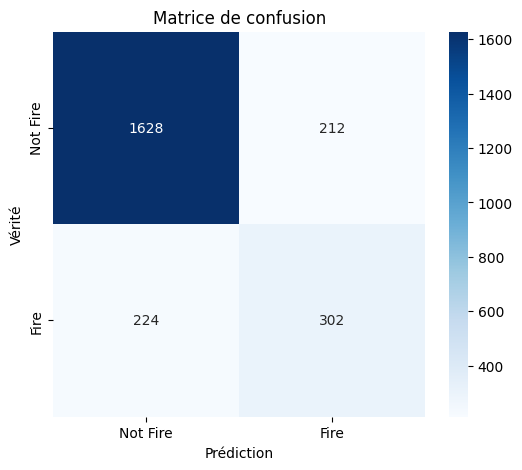

In [3]:
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# -----------------------------
# Charger le GeoPackage
# -----------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg")

# Ignorer la géométrie
df = gdf.drop(columns="geometry")

# Convertir la colonne cible True/False en 0/1
df['fire'] = df['fire'].astype(int)  # remplacer 'fire' par le vrai nom de votre colonne cible

# Séparer features et target
X = df.drop(columns=['fire']).values
y = df['fire'].values

# Séparer train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# -----------------------------
# Normaliser les features
# -----------------------------

X_train_scaled=X_train
X_test_scaled = X_test

# -----------------------------
# Appliquer KNN
# -----------------------------
k = 3

knn = KNeighborsClassifier(metric="minkowski", p=1)
knn.fit(X_train_scaled, y_train)

# Prédictions
y_pred = knn.predict(X_test_scaled)

# -----------------------------
# Évaluer le modèle
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
conf_matrix = confusion_matrix(y_test, y_pred)

# Labels pour les classes
labels = ['Not Fire', 'Fire']  # adapter si nécessaire

# Affichage heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.title('Matrice de confusion')
plt.show()


#Undersampling

## TOMEK

tomek does not balance ? chooses pairs where instaces are each others closest neighbors and both from different classes : their number is limited


=== Class distribution BEFORE Tomek Links ===
Class 1: 2629 samples (22.23%)
Class 0: 9200 samples (77.77%)


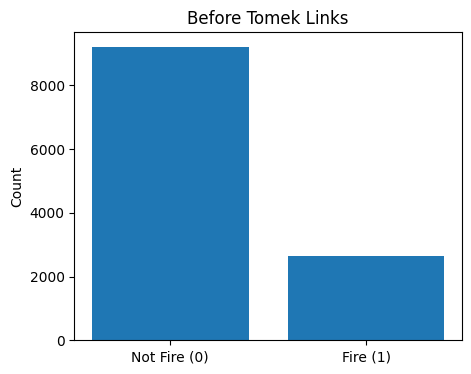


Shape original : (11829, 21)
Shape après Tomek : (11297, 21)

=== Class distribution AFTER Tomek Links ===
Counter({np.int64(0): 8668, np.int64(1): 2629})


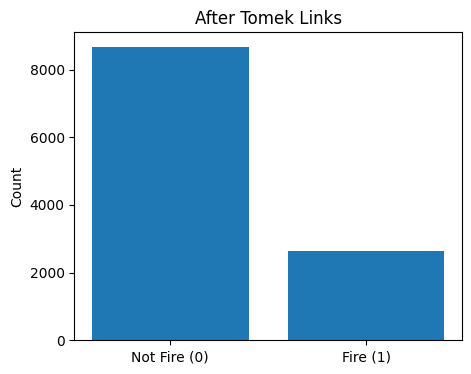


=== KNN RESULTS ===
Accuracy : 0.84
Precision: 0.66
Recall   : 0.66
F1-score : 0.66


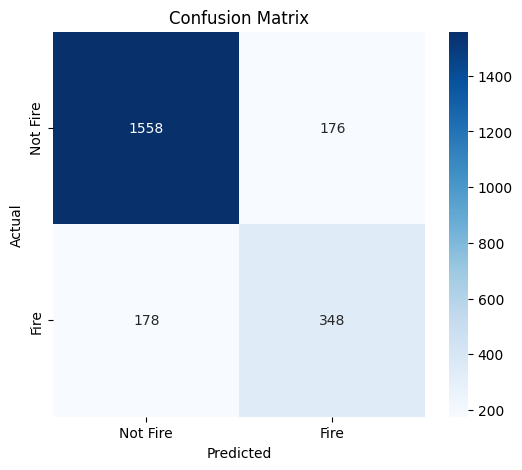

In [4]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import TomekLinks  # FIXED missing import


# -----------------------------
# Load dataset
# -----------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg")
df = gdf.drop(columns="geometry")

df['fire'] = df['fire'].astype(int)

X = df.drop(columns=['fire']).values
y = df['fire'].values



# -----------------------------
# Class distribution BEFORE Tomek
# -----------------------------
orig_counts = Counter(df['fire'])
total = sum(orig_counts.values())

print("\n=== Class distribution BEFORE Tomek Links ===")
for cls, count in orig_counts.items():
    pct = 100 * count / total
    print(f"Class {cls}: {count} samples ({pct:.2f}%)")


plt.figure(figsize=(5,4))
plt.bar(orig_counts.keys(), orig_counts.values())
plt.xticks([0,1], ["Not Fire (0)", "Fire (1)"])
plt.title("Before Tomek Links")
plt.ylabel("Count")
plt.show()


# -----------------------------
# === APPLICATION TOMEK LINKS ===
# -----------------------------
tl = TomekLinks(sampling_strategy='majority')
X_res, y_res = tl.fit_resample(X, y)

print("\nShape original :", X.shape)
print("Shape après Tomek :", X_res.shape)


# -----------------------------
# Class distribution AFTER Tomek
# -----------------------------
post_counts = Counter(y_res)
print("\n=== Class distribution AFTER Tomek Links ===")
print(post_counts)

plt.figure(figsize=(5,4))
plt.bar(post_counts.keys(), post_counts.values())
plt.xticks([0,1], ["Not Fire (0)", "Fire (1)"])
plt.title("After Tomek Links")
plt.ylabel("Count")
plt.show()


# -----------------------------
# Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42,stratify=y_res
)

# No scaling needed because your data is already normalized
X_train_scaled = X_train
X_test_scaled = X_test


# -----------------------------
# KNN classifier
# -----------------------------
k = 3
knn = knn = KNeighborsClassifier(metric="minkowski", p=1)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)


# -----------------------------
# Metrics
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n=== KNN RESULTS ===")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-score : {f1:.2f}")


# -----------------------------
# Confusion matrix
# -----------------------------
plt.figure(figsize=(6,5))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Fire','Fire'],
    yticklabels=['Not Fire','Fire']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



=== Class distribution BEFORE Tomek Links ===
Class 1: 2629 samples (22.23%)
Class 0: 9200 samples (77.77%)


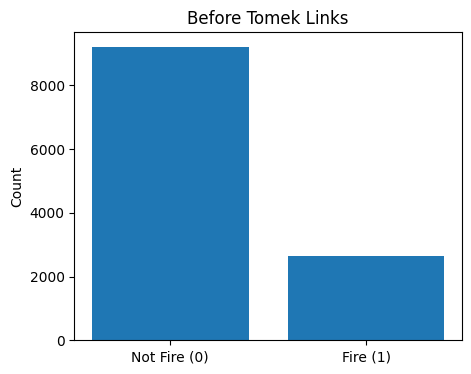


=== Tomek Iteration 1 ===
Not Fire: 76.73% | Fire: 23.27%

=== Tomek Iteration 2 ===
Not Fire: 76.44% | Fire: 23.56%

=== Tomek Iteration 3 ===
Not Fire: 76.36% | Fire: 23.64%

=== Tomek Iteration 4 ===
Not Fire: 76.35% | Fire: 23.65%

=== Tomek Iteration 5 ===
Not Fire: 76.34% | Fire: 23.66%

=== Tomek Iteration 6 ===
Aucun changement — arrêt pour éviter boucle infinie.

=== Distribution FINALE ===
Counter({np.int64(0): 8482, np.int64(1): 2629})


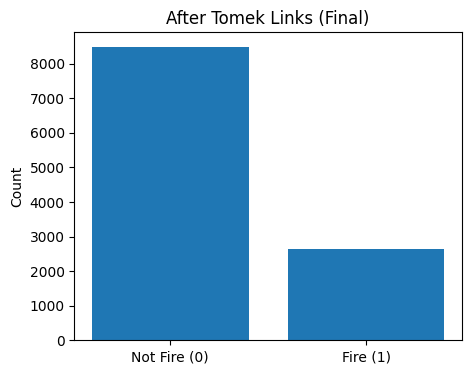


=== KNN RESULTS ===
Accuracy : 0.85
Precision: 0.68
Recall   : 0.67
F1-score : 0.68


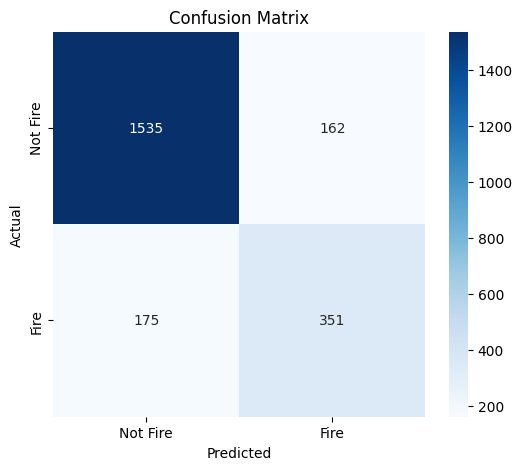

In [5]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from imblearn.under_sampling import TomekLinks


# -----------------------------
# Load dataset
# -----------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg")
df = gdf.drop(columns="geometry")

df['fire'] = df['fire'].astype(int)

X = df.drop(columns=['fire']).values
y = df['fire'].values



# -----------------------------
# Class distribution BEFORE Tomek
# -----------------------------
orig_counts = Counter(df['fire'])
total = sum(orig_counts.values())

print("\n=== Class distribution BEFORE Tomek Links ===")
for cls, count in orig_counts.items():
    pct = 100 * count / total
    print(f"Class {cls}: {count} samples ({pct:.2f}%)")

plt.figure(figsize=(5,4))
plt.bar(orig_counts.keys(), orig_counts.values())
plt.xticks([0,1], ["Not Fire (0)", "Fire (1)"])
plt.title("Before Tomek Links")
plt.ylabel("Count")
plt.show()



# -----------------------------------------------------
#  LOOP TOMEK LINKS UNTIL 40% FIRE / 60% NOT FIRE
# -----------------------------------------------------
target_fire = 0.40
target_notfire = 0.60

X_current = X.copy()
y_current = y.copy()

max_iter = 50
iteration = 0

while iteration < max_iter:
    iteration += 1
    print(f"\n=== Tomek Iteration {iteration} ===")

    tl = TomekLinks(sampling_strategy='majority')
    X_res, y_res = tl.fit_resample(X_current, y_current)

    # Stop if no change
    if len(y_res) == len(y_current):
        print("Aucun changement — arrêt pour éviter boucle infinie.")
        break

    X_current = X_res
    y_current = y_res

    counts = Counter(y_current)
    n_fire = counts[1]
    n_notfire = counts[0]
    total = n_fire + n_notfire

    pct_fire = n_fire / total
    pct_notfire = n_notfire / total

    print(f"Not Fire: {pct_notfire*100:.2f}% | Fire: {pct_fire*100:.2f}%")

    # Stop when reaching 40%
    if abs(pct_fire - target_fire) < 0.01:
        print("🎯 Distribution 40% / 60% atteinte !")
        break


print("\n=== Distribution FINALE ===")
final_counts = Counter(y_current)
print(final_counts)



# -----------------------------
# Plot distribution AFTER Tomek
# -----------------------------
plt.figure(figsize=(5,4))
plt.bar(final_counts.keys(), final_counts.values())
plt.xticks([0,1], ["Not Fire (0)", "Fire (1)"])
plt.title("After Tomek Links (Final)")
plt.ylabel("Count")
plt.show()


# Replace X_res & y_res with final balanced data
X_res = X_current
y_res = y_current



# -----------------------------
# Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42,stratify=y_res
)

# Data already normalized
X_train_scaled = X_train
X_test_scaled = X_test



# -----------------------------
# KNN classifier
# -----------------------------
k = 3
knn = KNeighborsClassifier(metric="minkowski", p=1)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)



# -----------------------------
# Metrics
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n=== KNN RESULTS ===")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-score : {f1:.2f}")



# -----------------------------
# Confusion matrix
# -----------------------------
plt.figure(figsize=(6,5))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Fire','Fire'],
    yticklabels=['Not Fire','Fire']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#Random undersampling


=== CLASS DISTRIBUTION (BEFORE) ===
Not Fire (0): 9200 → 77.77%
Fire     (1): 2629 → 22.23%


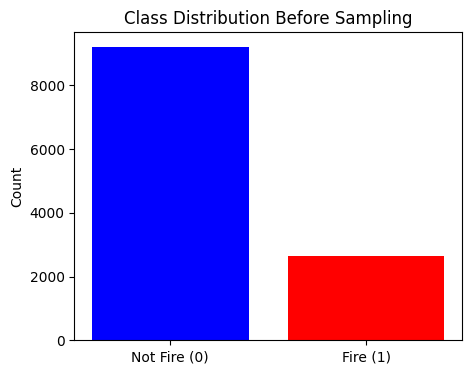

Fire count kept: 2629
Target Not Fire count: 3943

=== CLASS DISTRIBUTION (AFTER) ===
Not Fire (0): 3943 → 60.00%
Fire     (1): 2629 → 40.00%


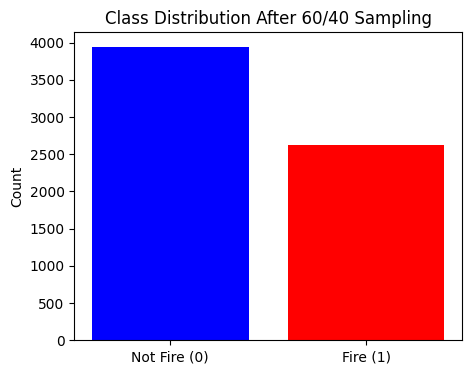


=== KNN RESULTS ===
Accuracy : 0.78
Precision: 0.71
Recall   : 0.77
F1-score : 0.74


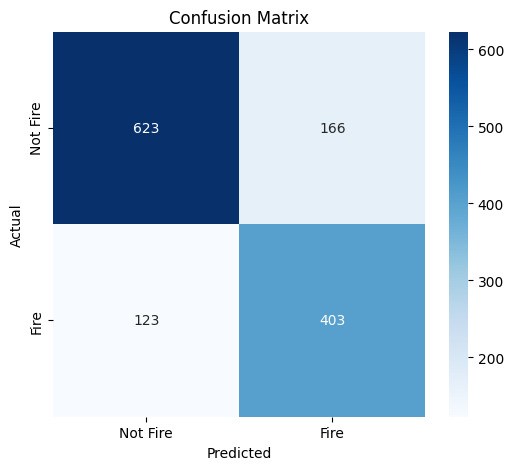

In [6]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample

# -----------------------------
# Load dataset
# -----------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg")
df = gdf.drop(columns="geometry")

df['fire'] = df['fire'].astype(int)

X = df.drop(columns=['fire']).values
y = df['fire'].values

# -----------------------------
# 1️⃣ Class distribution BEFORE sampling
# -----------------------------
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))

total = len(y)
percent_0 = (counts[unique.tolist().index(0)] / total) * 100
percent_1 = (counts[unique.tolist().index(1)] / total) * 100

print("\n=== CLASS DISTRIBUTION (BEFORE) ===")
print(f"Not Fire (0): {counts[0]} → {percent_0:.2f}%")
print(f"Fire     (1): {counts[1]} → {percent_1:.2f}%")

# Bar chart
plt.figure(figsize=(5,4))
plt.bar(['Not Fire (0)', 'Fire (1)'], counts, color=['blue','red'])
plt.title("Class Distribution Before Sampling")
plt.ylabel("Count")
plt.show()
# -----------------------------
# 2️⃣ UNDERSAMPLING: only Not Fire → target ratio 60/40
# -----------------------------
X_fire = X[y == 1]        # KEEP ALL FIRE
X_notfire = X[y == 0]     # Undersample this

# Count fire samples
n_fire = len(X_fire)

# Compute target NOT FIRE = 60% / 40% ratio
n_notfire_target = int(n_fire * (60/40))

print("Fire count kept:", n_fire)
print("Target Not Fire count:", n_notfire_target)

# Undersample only NOT FIRE
X_notfire_under, y_notfire_under = resample(
    X_notfire, y[y == 0],
    replace=False,
    n_samples=n_notfire_target,
    random_state=42
)

# Keep all fire samples
X_fire_under = X_fire
y_fire_under = y[y == 1]

# Merge dataset
X_res = np.vstack((X_notfire_under, X_fire_under))
y_res = np.concatenate((y_notfire_under, y_fire_under))


# New distribution
unique2, counts2 = np.unique(y_res, return_counts=True)
total = len(y_res)
percent_0 = (counts2[unique2.tolist().index(0)] / total) * 100
percent_1 = (counts2[unique2.tolist().index(1)] / total) * 100

print("\n=== CLASS DISTRIBUTION (AFTER) ===")
print(f"Not Fire (0): {counts2[0]} → {percent_0:.2f}%")
print(f"Fire     (1): {counts2[1]} → {percent_1:.2f}%")

plt.figure(figsize=(5,4))
plt.bar(['Not Fire (0)', 'Fire (1)'], counts2, color=['blue','red'])
plt.title("Class Distribution After 60/40 Sampling")
plt.ylabel("Count")
plt.show()

# -----------------------------
# Train/Test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42,stratify=y_res
)


X_train_scaled =X_train
X_test_scaled =X_test

# -----------------------------
# 3️⃣ KNN
# -----------------------------
k = 3
knn = KNeighborsClassifier(metric="minkowski", p=1)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n=== KNN RESULTS ===")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-score : {f1:.2f}")

# Confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fire','Fire'], yticklabels=['Not Fire','Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#Oversampling

##Adaptaive synthetic

yad3am fire, especially knn so fire ponts will have closer points fire and will be classified as fire --> less false negatives


=== CLASS DISTRIBUTION (BEFORE) ===
Not Fire (0): 9200 → 77.77%
Fire     (1): 2629 → 22.23%


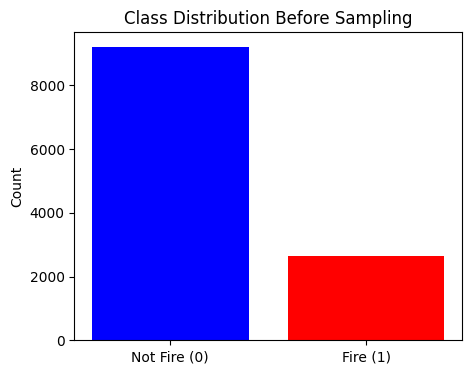


=== CLASS DISTRIBUTION (AFTER ADASYN) ===
Not Fire (0): 9200 → 59.46%
Fire     (1): 6273 → 40.54%


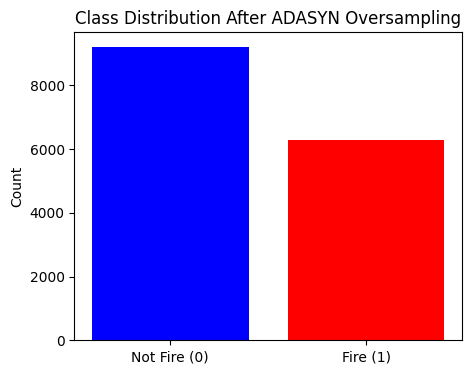


=== KNN RESULTS ===
Accuracy : 0.83
Precision: 0.74
Recall   : 0.90
F1-score : 0.81


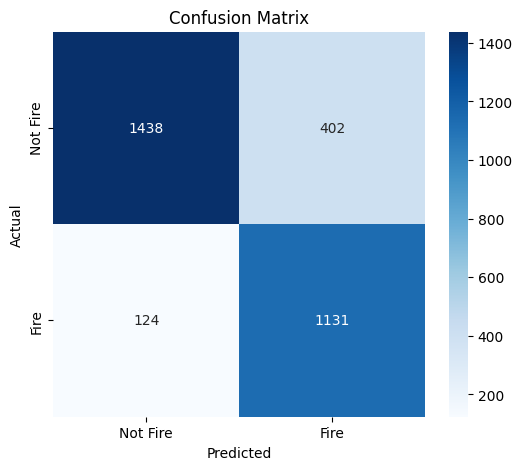

In [9]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN

# -----------------------------
# Load dataset
# -----------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg")
df = gdf.drop(columns="geometry")

df['fire'] = df['fire'].astype(int)

X = df.drop(columns=['fire']).values
y = df['fire'].values

# -----------------------------
# 1️⃣ Class distribution BEFORE sampling
# -----------------------------
unique, counts = np.unique(y, return_counts=True)
total = len(y)
percent_0 = (counts[unique.tolist().index(0)] / total) * 100
percent_1 = (counts[unique.tolist().index(1)] / total) * 100

print("\n=== CLASS DISTRIBUTION (BEFORE) ===")
print(f"Not Fire (0): {counts[0]} → {percent_0:.2f}%")
print(f"Fire     (1): {counts[1]} → {percent_1:.2f}%")

plt.figure(figsize=(5,4))
plt.bar(['Not Fire (0)', 'Fire (1)'], counts, color=['blue','red'])
plt.title("Class Distribution Before Sampling")
plt.ylabel("Count")
plt.show()

# -----------------------------
# 2️⃣ ADASYN: Adaptive Synthetic Oversampling
# -----------------------------
# Current counts
N_fire_original = np.sum(y == 1)
N_notfire = np.sum(y == 0)

# Desired final counts
N_fire_target = int((2/3) * N_notfire)  # 40% fire / 60% not fire

# Use dict for sampling_strategy
sampling_strategy = {1: N_fire_target}

adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=42)
X_res, y_res = adasyn.fit_resample(X, y)


# New distribution
unique2, counts2 = np.unique(y_res, return_counts=True)
total2 = len(y_res)
percent_0_res = (counts2[unique2.tolist().index(0)] / total2) * 100
percent_1_res = (counts2[unique2.tolist().index(1)] / total2) * 100

print("\n=== CLASS DISTRIBUTION (AFTER ADASYN) ===")
print(f"Not Fire (0): {counts2[0]} → {percent_0_res:.2f}%")
print(f"Fire     (1): {counts2[1]} → {percent_1_res:.2f}%")

plt.figure(figsize=(5,4))
plt.bar(['Not Fire (0)', 'Fire (1)'], counts2, color=['blue','red'])
plt.title("Class Distribution After ADASYN Oversampling")
plt.ylabel("Count")
plt.show()

# -----------------------------
# Train/Test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42,stratify=y_res
)

# -----------------------------
# KNN
# -----------------------------
k = 3
knn = KNeighborsClassifier(metric="minkowski", p=1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n=== KNN RESULTS ===")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-score : {f1:.2f}")

# Confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fire','Fire'], yticklabels=['Not Fire','Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#Combinaison

## ADASYN --> TOMEK

In [ ]:
# le probleme is that its confusing the new genrated fire points and predicting not fire as fire


=== Original distribution ===
Class 0: 9200 samples (77.77%)
Class 1: 2629 samples (22.23%)

=== After ADASYN (40/60) ===
Class 0: 9200 samples (59.46%)
Class 1: 6273 samples (40.54%)

=== Final distribution (~45/55) ===
Class 0: 6889 samples (52.34%)
Class 1: 6273 samples (47.66%)

=== KNN RESULTS ===
Accuracy : 0.82
Precision: 0.76
Recall   : 0.93
F1-score : 0.84


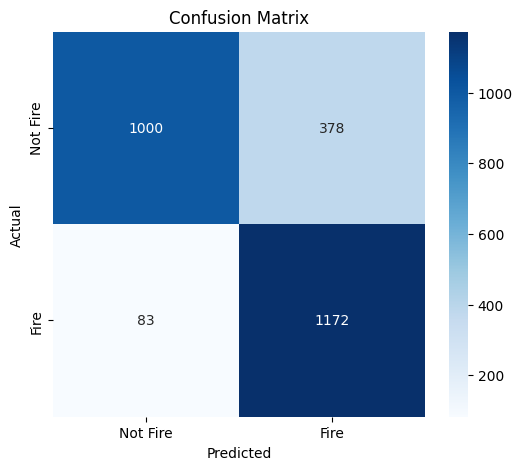

In [13]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from sklearn.utils import resample

# -----------------------------
# Helper function to print distribution
# -----------------------------
def print_distribution(y, title="Distribution"):
    unique, counts = np.unique(y, return_counts=True)
    total = sum(counts)
    print(f"\n=== {title} ===")
    for cls, count in zip(unique, counts):
        pct = 100 * count / total
        print(f"Class {int(cls)}: {int(count)} samples ({pct:.2f}%)")

# -----------------------------
# Load dataset
# -----------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg")
df = gdf.drop(columns="geometry")
df['fire'] = df['fire'].astype(int)

X = df.drop(columns=['fire']).values
y = df['fire'].values

# -----------------------------
# 1️⃣ Original distribution
# -----------------------------
print_distribution(y, "Original distribution")

# -----------------------------
# 2️⃣ Step 1: Oversample minority (Fire) using ADASYN
# Target ~40% Fire / 60% Not Fire
# -----------------------------
N_notfire = np.sum(y == 0)
N_fire_target = int((40/60) * N_notfire)

adasyn = ADASYN(sampling_strategy={1: N_fire_target}, random_state=42)
X_res, y_res = adasyn.fit_resample(X, y)

print_distribution(y_res, "After ADASYN (40/60)")

# -----------------------------
# 3️⃣ Step 2: Tomek Links to clean noisy majority samples
# -----------------------------
tl = TomekLinks(sampling_strategy='majority')
X_res2, y_res2 = tl.fit_resample(X_res, y_res)

# -----------------------------
# 4️⃣ Optional manual adjustment to ~45/55
# -----------------------------
total = len(y_res2)
target_fire = int(0.55 * total)
target_notfire = total - target_fire

X_fire_final = X_res2[y_res2 == 1]
y_fire_final = y_res2[y_res2 == 1]
X_notfire_final = X_res2[y_res2 == 0]
y_notfire_final = y_res2[y_res2 == 0]

if len(X_notfire_final) > target_notfire:
    X_notfire_final, y_notfire_final = resample(
        X_notfire_final, y_notfire_final,
        replace=False,
        n_samples=target_notfire,
        random_state=42
    )

# Merge final dataset
X_final = np.vstack((X_fire_final, X_notfire_final))
y_final = np.concatenate((y_fire_final, y_notfire_final))

print_distribution(y_final, "Final distribution (~45/55)")

# -----------------------------
# 5️⃣ Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42,stratify=y_final
)

# -----------------------------
# 6️⃣ KNN classifier
# -----------------------------
k = 3
knn = KNeighborsClassifier(metric="minkowski", p=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# -----------------------------
# 7️⃣ Evaluation
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n=== KNN RESULTS ===")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1-score : {f1:.2f}")

# -----------------------------
# Confusion matrix plot
# -----------------------------
plt.figure(figsize=(6,5))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Fire','Fire'],
    yticklabels=['Not Fire','Fire']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
